### First, import necessary packages:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import Calculation as cln

Using CAMB 1.0.4 installed at /Users/cheng/anaconda3/lib/python3.7/site-packages/camb-1.0.4-py3.7.egg/camb
Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201


### Second, we generate the set of M2i(x) special functions
#### Here we take galaxy-clustering for example:

In [2]:
func_real_list, func_imag_list = cln.special_func_generator()

Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-07 , 10000000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 4.173194368680318 min


### Third, we could calculate the angular power spectrum

Note that, although Calculation.py has a default initial matter power spectrum implemented, here we show how can we choose another set of cosmology.

When we change the cosmology, we do not need to change the resulting func_real_list and func_imag_list

In [3]:
import Cosmology as Csm
import params as pa
sampling_cosmo = Csm.Sampling(pa.c, pa.zCMB, pa.zmax, pa.h, pa.omch2, pa.ombh2, pa.ns, pa.s8)
khmin = 1e-8
khmax = 52.0
Nmax = 200
c_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, Nmax, khmin, khmax)[:, 0]

#### For equal time case: $z_1=z_2=1.0$, $\sigma_z = 0.05$:

In [8]:
our_l = np.array([2+i for i in range(98)]+[100+10*i for i in range(41)])

In [10]:
Cl_1_1_005 = cln.full_calc_sampling(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)

Time for preparing mesh-grids is: 10.052799940109253 s
Time for calculating each l is: 0.12147795039115192 s


#### Calculate our geometric modification:

In [11]:
Cl_1_1_005_mod = cln.full_calc_sampling_mod(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)

Time for preparing mesh-grids is: 9.52956509590149 s
Time for calculating each l is: 0.11616563282424597 s


#### For unequal time case: $z_1=2.0, z_2=3.5$, $\sigma_z = 0.3$:

In [12]:
Cl_2_35_03 = cln.full_calc_sampling(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl_2_35_03_mod = cln.full_calc_sampling_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)

Time for preparing mesh-grids is: 9.214615106582642 s
Time for calculating each l is: 0.11361699138613914 s
Time for preparing mesh-grids is: 8.743267059326172 s
Time for calculating each l is: 0.11402416400772204 s


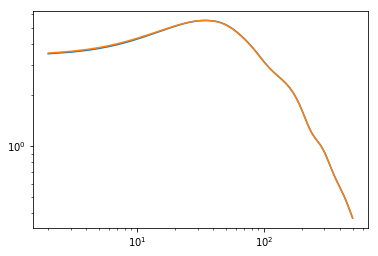

In [13]:
plt.loglog(our_l, Cl_1_1_005*1e6)
plt.loglog(our_l, Cl_1_1_005_mod*1e6)

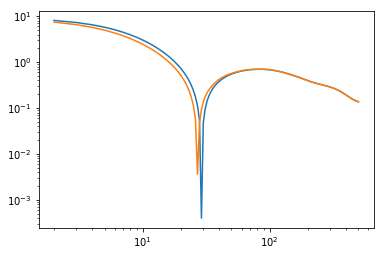

In [15]:
plt.loglog(our_l, np.abs(Cl_2_35_03)*1e9)
plt.loglog(our_l, np.abs(Cl_2_35_03_mod)*1e9)

### Now, we demonstrate the CMB lensing case:

In [16]:
func_real_list_lensing, func_imag_list_lensing = cln.special_func_generator_CMBlensing()

Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-06 , 100000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 4.873590052127838 min


In [17]:
Cl_CMBlensing = cln.full_calc_sampling_CMBlensing(our_l, 100, 110, c_n_array, func_real_list_lensing, func_imag_list_lensing)
Cl_CMBlensing_mod = cln.full_calc_sampling_CMBlensing_mod(our_l, 100, 110, c_n_array, func_real_list_lensing, func_imag_list_lensing)

(222, 100) (222, 100)
Time for preparing mesh-grids is: 40.23560690879822 s
Time for calculating each l is: 0.47889271914530146 s
(222, 100) (222, 100)
Time for preparing mesh-grids is: 40.36073088645935 s
Time for calculating each l is: 0.48030891521371527 s


In [28]:
Cl_CMBlensing_limber = np.array([cln.Limber_CMBlensing(li, 0.1, sampling_cosmo.default_cosmo.chi(1100)) for li in our_l])

### Plotting:

### Note that all the full-sky calculation is directly generated from Assassi's Mathematica code, and the Limber approximation for galaxy-clustering is pre-calculated

In [24]:
from scipy.interpolate import interp1d
def plot_compare(path_Aassassi, path_Limber, our_l, our_Cl, our_Cl_mod, ymin, ymax, xmin, xmax, rescale):

    l_Assassi = []
    Cl_Assassi = []
    with open(path_Aassassi,'r') as file:
        lines = file.readlines()
        for line in lines:
            l, C = line.split(',')
            l_Assassi.append(int(l))
            Cl_Assassi.append(float(C.strip('\n')))

    file.close()

    l_limber = np.load(path_Limber)[0,:]
    Cl_limber = np.load(path_Limber)[1,:]
    fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.05})
    ax0,ax1 = axes[0],axes[1]
   
    ax0.plot(our_l, np.abs(np.array(our_Cl))*rescale, color = 'r', label=r'OurApprox')
    ax0.plot(our_l, np.abs(np.array(our_Cl_mod))*rescale, color = 'g', label=r'OurApprox Modified')
    ax0.plot(l_limber, np.abs(Cl_limber)*rescale, '--', color = 'b', label=r'Limber')
    ax0.plot(l_Assassi, np.abs(np.array(Cl_Assassi))*rescale,'-.', color = 'k', label=r'FullSky')

    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylim(ymin, ymax)
    ax0.set_xlim(xmin, xmax)
    ax0.legend()
    ax0.set_ylabel(r'$C_{\ell}^{g}\ (\times 10^{%d})$'%np.log10(rescale), fontsize=15)
    ax0.tick_params(labelsize=15)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(our_l, (our_Cl/Cl_Assassi-1)*100, color='r')
    ax1.plot(our_l[:-1], (Cl_limber/np.array(Cl_Assassi)[:-1]-1)*100,'--', color='b')
    ax1.plot(our_l, (our_Cl_mod/Cl_Assassi-1)*100, color='g')
    ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
    ax1.set_xscale('log')
    ax1.set_ylim(-20, 20)
    ax1.set_xlim(xmin, xmax)
    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_xlabel(r'$\ell$',fontsize=15)
    ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)

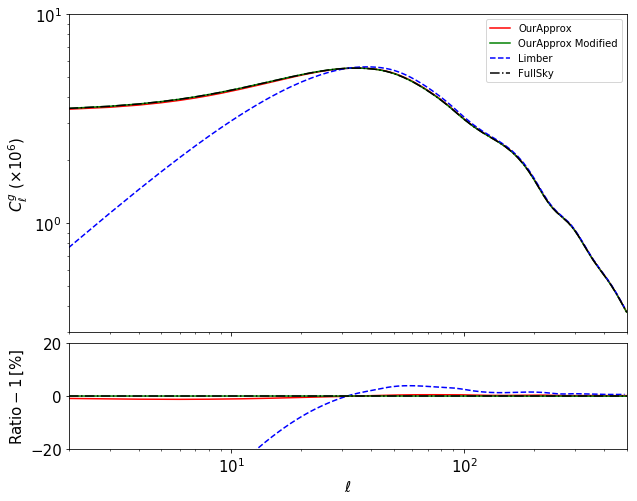

In [25]:
plot_compare('./Full-sky/z1_1_z2_1.txt',\
    './Limber/z1_1_z2_1_005.npy', np.array(our_l), Cl_1_1_005, Cl_1_1_005_mod, 0.3, 10, 2, 500, 1e6)

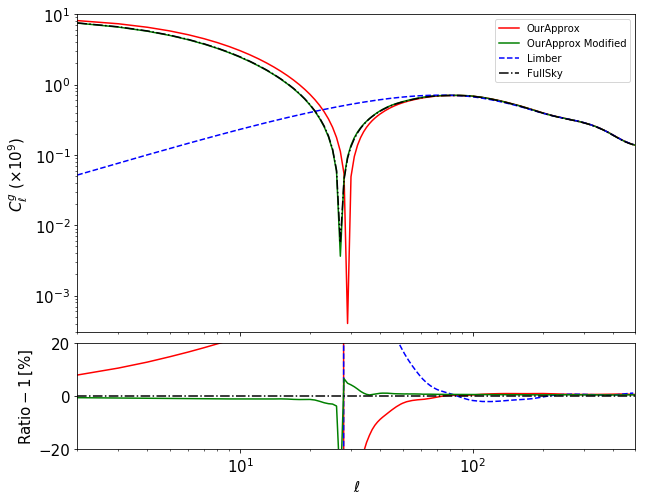

In [26]:
plot_compare('./Full-sky/z1_2_z2_35.txt',\
    './Limber/z1_2_z2_35_03.npy', np.array(our_l), Cl_2_35_03, Cl_2_35_03_mod, 0.0003, 10, 2, 500, 1e9)

Text(0, 0.5, '$\\rm Ratio-1\\,[\\%]$')

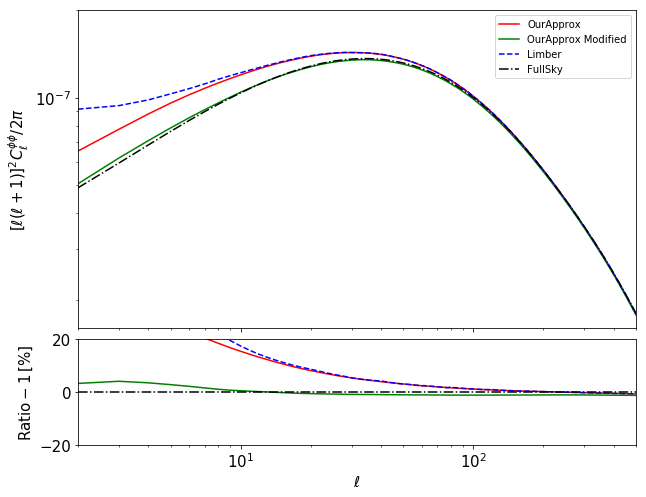

In [29]:
l_Assassi_lensing = []
Cl_Assassi_lensing = []
Assassi_file_path = './Full-sky/ClCAMB.txt'
with open(Assassi_file_path,'r') as file:
    lines = file.readlines()
    for line in lines:
        l, C = line.split(',')
        l_Assassi_lensing.append(int(l))
        Cl_Assassi_lensing.append(float(C.strip('\n')))

file.close()
l_lensing = np.array(l_Assassi_lensing)[:500]
Cl_Assassi_lensing_array = np.array(Cl_Assassi_lensing)[:500]

fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]

ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing/(2*np.pi), color = 'r', label=r'OurApprox')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_mod/(2*np.pi), color = 'g', label=r'OurApprox Modified')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_limber/(2*np.pi), '--', color = 'b', label=r'Limber')
#ax0.plot(l_prime, np.abs(np.array(our_Cl))*rescale, color = 'g', label=r'OurApprox Modified')
ax0.plot(l_lensing, (l_lensing*(l_lensing+1))**2*Cl_Assassi_lensing_array/(2*np.pi),'-.', color = 'k', label=r'FullSky')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(1.6e-8, 2e-7)
ax0.set_xlim(2, 500)
ax0.legend()
#ax0.xlabel(r'$\ell$',fontsize=15)
ax0.set_ylabel(r'$[\ell(\ell+1)]^2C_{\ell}^{\phi\phi}/2\pi$', fontsize=15)
ax0.tick_params(labelsize=15)
plt.setp(ax0.get_xticklabels(), visible=False)
func_full = interp1d(l_lensing, Cl_Assassi_lensing_array)
ax1.plot(our_l, (Cl_CMBlensing/func_full(our_l)-1)*100, color='r')
ax1.plot(our_l, (Cl_CMBlensing_limber/func_full(our_l)-1)*100,'--', color='b')
ax1.plot(our_l, (Cl_CMBlensing_mod/func_full(our_l)-1)*100, color='g')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
ax1.set_xscale('log')
ax1.set_ylim(-20, 20)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel(r'$\ell$',fontsize=15)
ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)